# Simple VARMAX

This code template is for Time Series Analysis and Forecasting to make scientific predictions based on historical time stamped data with the help of VARMAX algorithm


### Required Packages

In [ ]:
!pip install pmdarima

In [ ]:
import warnings 
import numpy as np
import pandas as pd 
import seaborn as se 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.model_selection import train_test_split as time_train_test_split
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")


### Initialization

Filepath of CSV file

In [ ]:
file_path=""

Variable containing the date time column name of the Time Series data

In [ ]:
date = ""

List of features which are  required for prediction .

In [ ]:
features = []

List of targets required for prediction (more than one target required for prediction)

In [ ]:
targets = []

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [ ]:
df = pd.read_csv(file_path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,20197.017578,20197.017578,19892.089844,19907.673828,19907.673828,5.091154e+08
1,2015-01-02,19896.906250,19983.132813,19864.343750,19932.076172,19932.076172,4.973433e+08
2,2015-01-03,19920.306641,19939.541016,17784.058594,17784.058594,17784.058594,2.091352e+09
3,2015-01-04,17788.107422,18173.042969,16299.111328,16715.617188,16715.617188,3.519653e+09
4,2015-01-05,16771.865234,17625.943359,16771.865234,17385.183594,17385.183594,2.784604e+09


### Data Preprocessing

Since the majority of the machine learning models for Time Series Forecasting doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippets have functions, which removes the rows containing null value if any exists. And convert the string classes date column in the datasets to proper Date-time classes.

After the proper date conversions are done and null values are dropped, we set the Date column as the index value.


In [ ]:
def data_preprocess(df, target, date):
    df = df.dropna(axis=0, how = 'any')
    df[date] = pd.to_datetime(df[date])
    df = df.set_index(date)
    return df

In [ ]:
df = data_preprocess(df,features,date)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,20197.017578,20197.017578,19892.089844,19907.673828,19907.673828,5.091154e+08
2015-01-02,19896.906250,19983.132813,19864.343750,19932.076172,19932.076172,4.973433e+08
2015-01-03,19920.306641,19939.541016,17784.058594,17784.058594,17784.058594,2.091352e+09
2015-01-04,17788.107422,18173.042969,16299.111328,16715.617188,16715.617188,3.519653e+09
2015-01-05,16771.865234,17625.943359,16771.865234,17385.183594,17385.183594,2.784604e+09


Visualizing the targets before performing seasonality decomposition to the target features

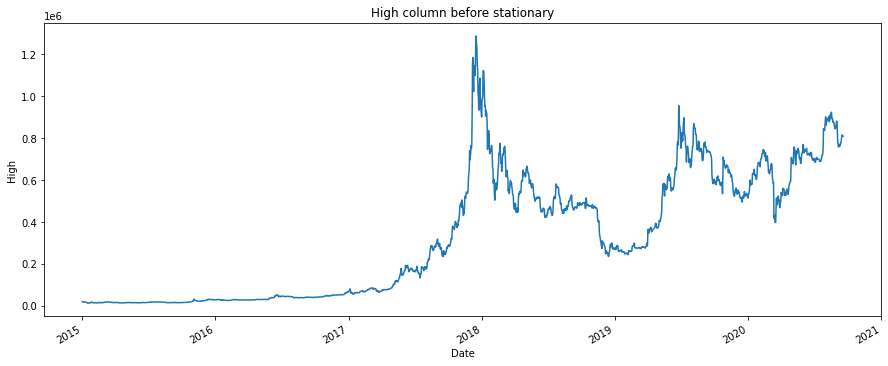

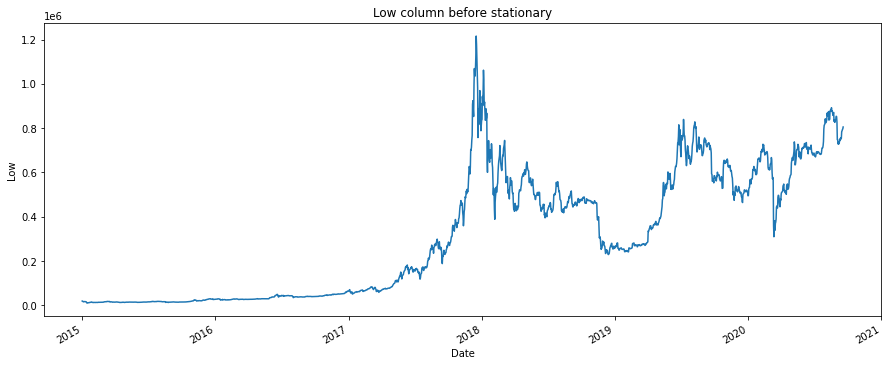

In [ ]:
for t in targets:
    df[str(t)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(t)
    plt.title(f"{str(t)} column before stationary")
    plt.show()

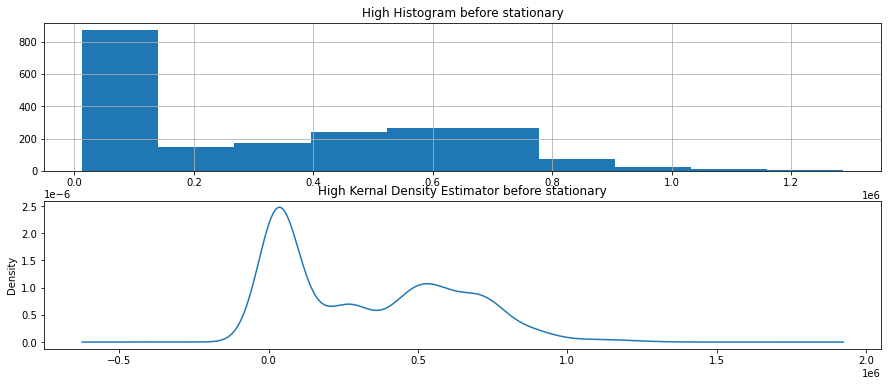

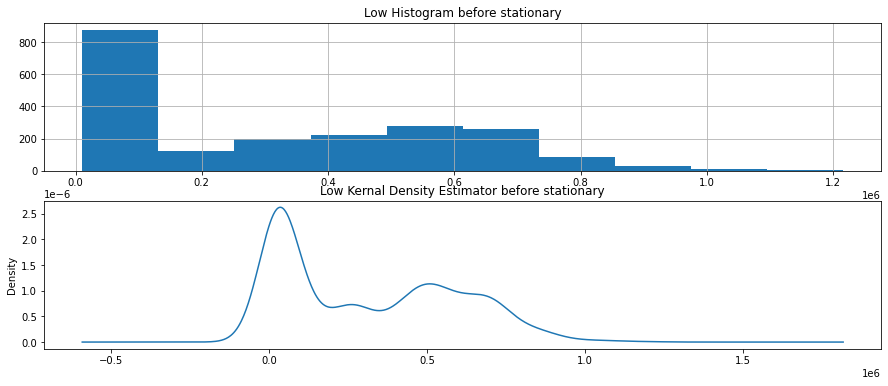

In [ ]:
for f in targets:
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f"{f} Histogram before stationary")
    df[f].hist()
    plt.subplot(212)
    df[f].plot(kind='kde')
    plt.title(f"{f} Kernal Density Estimator before stationary")
    plt.show()

### Autocorrelation Plot


We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.
A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. 

An autocorrelation plot shows whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. 
The plot shows the value of the autocorrelation function (acf) on the vertical axis ranging from –1 to 1.
There are vertical lines (a “spike”) corresponding to each lag and the height of each spike shows the value of the autocorrelation function for the lag.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)

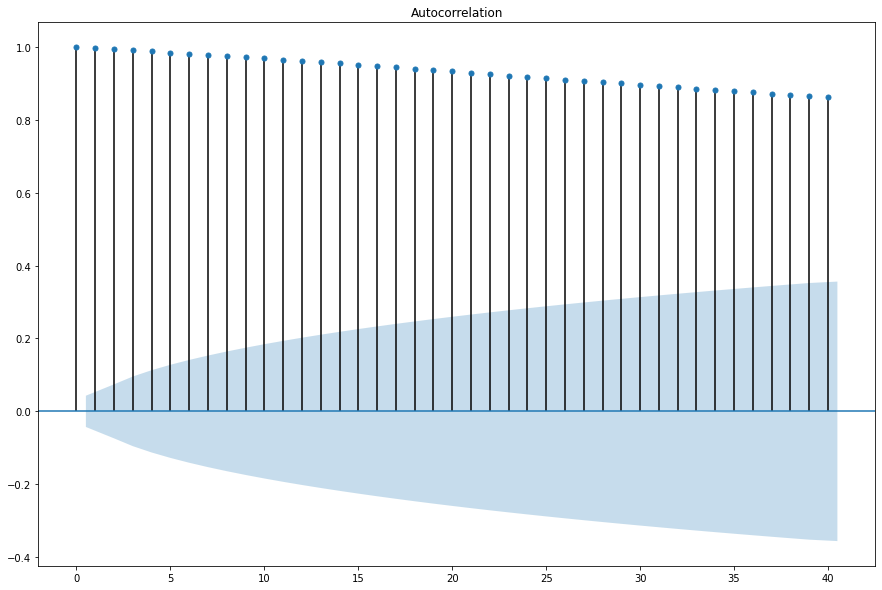

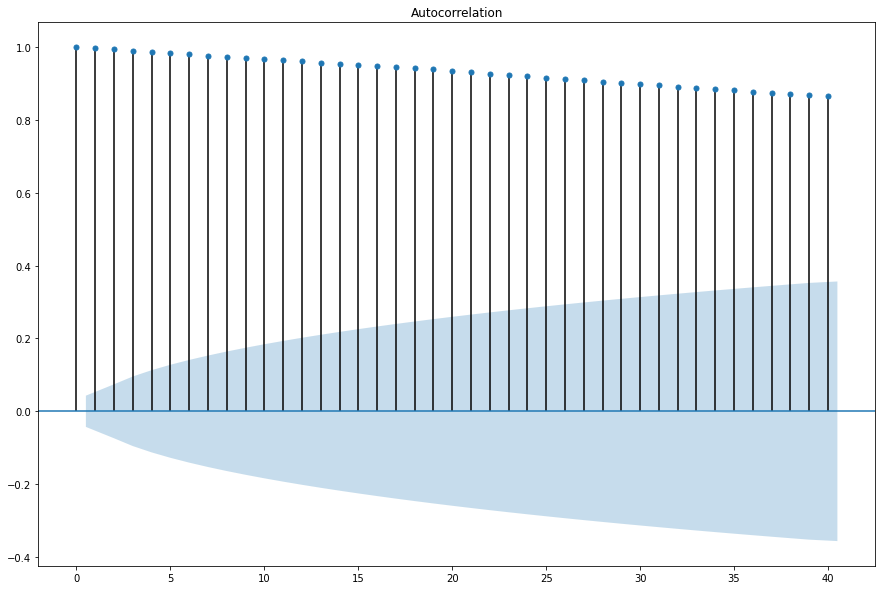

In [ ]:
for t in targets:
  x = plot_acf(df[t], lags=40)
  x.set_size_inches(15, 10, forward=True)
  plt.show()

### Partial Autocorrelation Plot

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. By examining the spikes at each lag we can determine whether they are significant or not. A significant spike will extend beyond the significant limits, which indicates that the correlation for that lag doesn't equal zero.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html)


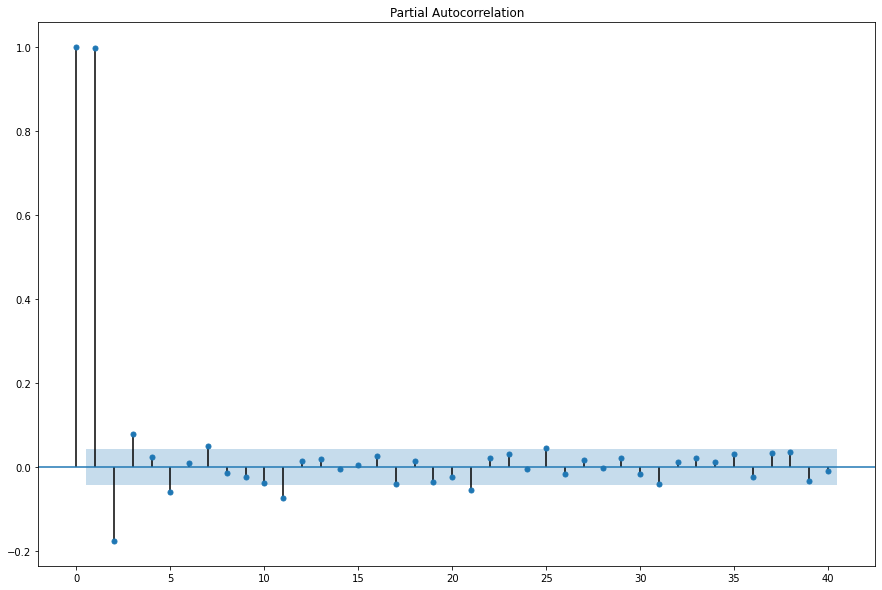

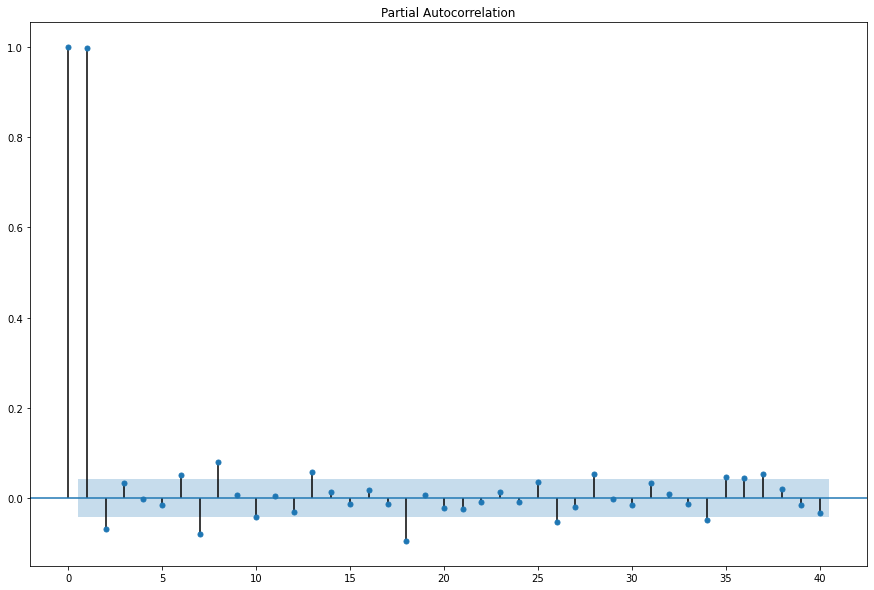

In [ ]:
for f in targets:
  y = plot_pacf(df[f], lags=40)
  y.set_size_inches(15, 10, forward=True)
  plt.show()

### Seasonality decomposition

Since Simple VARMAX for non-seasonal data, we need to check for any seasonality in our time series and decompose it.

We use the Dickey Fuller Test for testing the seasonality and if the ADF Statistic value is positive, it means that the data has seasonality.

#### Dickey Fuller Test
The Dickey Fuller test is a common statistical test used to test whether a given Time series is stationary or not. The Augmented Dickey Fuller (ADF) test expands the Dickey-Fuller test equation to include high order regressive process in the model. We can implement the ADF test via the **adfuller()** function. It returns the following outputs:

    1. adf : float
> The test statistic.

    2. pvalue : float
> MacKinnon's approximate p-value based on MacKinnon(1994, 2010). It is used alongwith the test statistic to reject or accept the null hypothesis.

    3. usedlag : int
> Number of lags considered for the test

    4. critical values : dict
> Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).

For more information on the adfuller() function [click here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    '''
    Calculates statistical values whether the available data are stationary or not 
    
    Args:
        series (float64): Values of the column for which stationarity is to be checked, numpy array of floats 
        column_name (str): Name of the column for which stationarity is to be checked
    
    Returns:
        p-value that indicates whether the data are stationary or not
    ''' 
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====> \n Accept the null hypothesis \n Data is stationary \n")
    else:
        print("Conclusion:====> \n Reject the null hypothesis \n Data is not stationary \n")



In [ ]:
for name, column in df[features + targets].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)

Results of Dickey-Fuller Test for column: Open
Test Statistic                   -1.556585
p-value                           0.505357
No Lags Used                     20.000000
Number of Observations Used    2067.000000
Critical Value (1%)              -3.433518
Critical Value (5%)              -2.862939
Critical Value (10%)             -2.567515
dtype: float64
Conclusion:====> 
 Reject the null hypothesis 
 Data is not stationary 

Results of Dickey-Fuller Test for column: Close
Test Statistic                   -1.567040
p-value                           0.500126
No Lags Used                     20.000000
Number of Observations Used    2067.000000
Critical Value (1%)              -3.433518
Critical Value (5%)              -2.862939
Critical Value (10%)             -2.567515
dtype: float64
Conclusion:====> 
 Reject the null hypothesis 
 Data is not stationary 

Results of Dickey-Fuller Test for column: High
Test Statistic                   -1.386436
p-value                           0.5

###Making Data Stationary


To remove the seasonality we use the rolling mean technique for smoothing our data and decomposing any seasonality.
This method provides rolling windows over the data. On the resulting windows, we can perform calculations using a statistical function (in this case the mean) in order to decompose the seasonality.

For more information about rolling function [click here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)

In [ ]:
Y = df[targets]
X = df[features]

In [ ]:
X_diff = X.diff()
Y_diff = Y.diff()
X_diff.dropna(inplace = True)
Y_diff.dropna(inplace = True)

In [ ]:
print("Making Data Stationary------------------------------------------------------------------------------>")
for name in X_diff[features]:
    Augmented_Dickey_Fuller_Test_func(X_diff[name],name)
for name in Y_diff[targets]:
    Augmented_Dickey_Fuller_Test_func(Y_diff[name],name)

Making Data Stationary------------------------------------------------------------------------------>
Results of Dickey-Fuller Test for column: Open
Test Statistic                -9.085145e+00
p-value                        3.958744e-15
No Lags Used                   2.600000e+01
Number of Observations Used    2.060000e+03
Critical Value (1%)           -3.433528e+00
Critical Value (5%)           -2.862944e+00
Critical Value (10%)          -2.567517e+00
dtype: float64
Conclusion:====> 
 Accept the null hypothesis 
 Data is stationary 

Results of Dickey-Fuller Test for column: Close
Test Statistic                -9.087580e+00
p-value                        3.902407e-15
No Lags Used                   2.600000e+01
Number of Observations Used    2.060000e+03
Critical Value (1%)           -3.433528e+00
Critical Value (5%)           -2.862944e+00
Critical Value (10%)          -2.567517e+00
dtype: float64
Conclusion:====> 
 Accept the null hypothesis 
 Data is stationary 

Results of Dickey-F

Visualization of Target features after performing seasonality decomposition to make the target features stationary

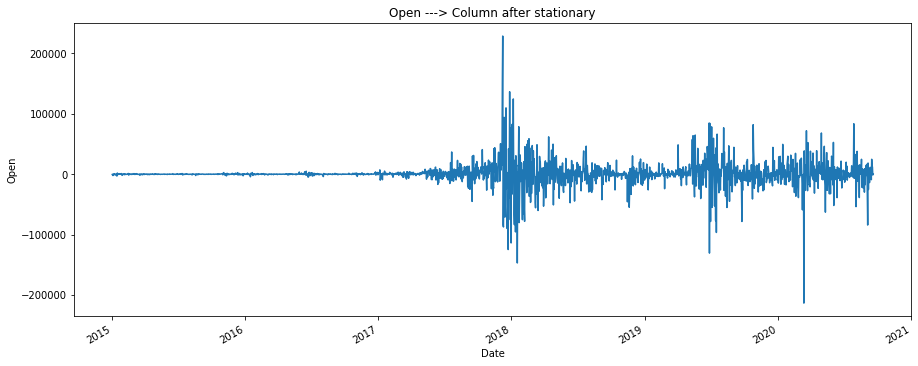

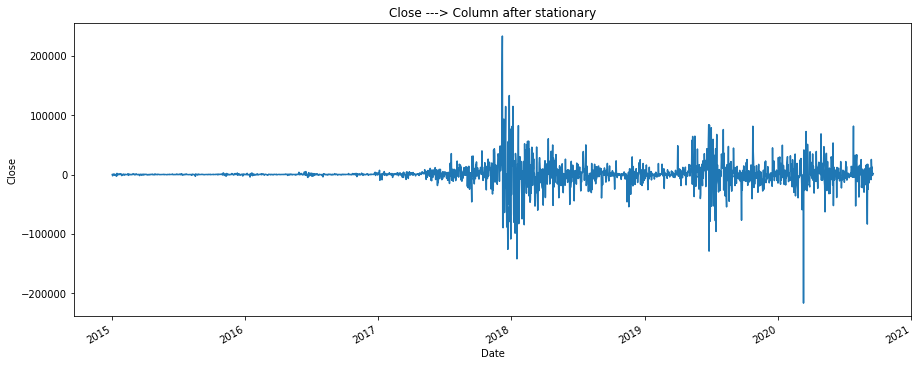

In [ ]:
for feature in X_diff:
    X_diff[feature].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{feature} ---> Column after stationary")
    plt.show()

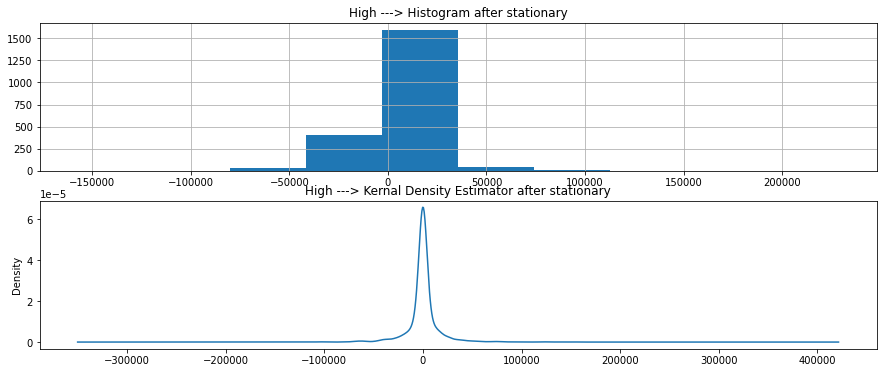

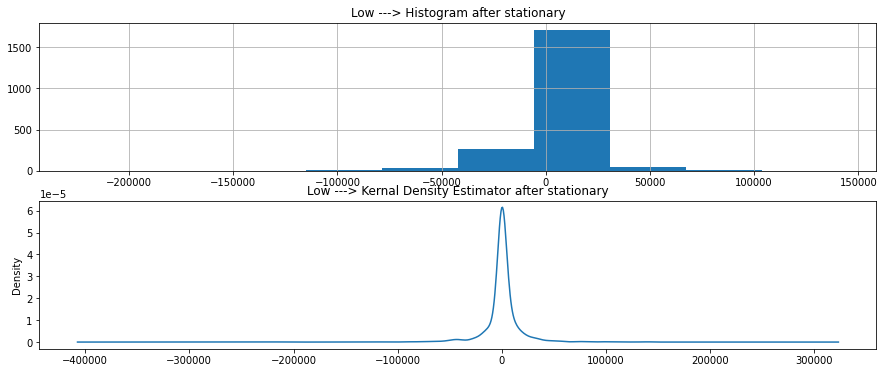

In [ ]:
for feature in Y_diff:
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f"{feature} ---> Histogram after stationary")
    Y_diff[feature].hist()
    plt.subplot(212)
    Y_diff[feature].plot(kind='kde')
    plt.title(f"{feature} ---> Kernal Density Estimator after stationary")
    plt.show()

### Data Splitting

Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [ ]:
X_train, X_test, Y_train, Y_test = time_train_test_split(X_diff, Y_diff, test_size=20)

### Model

Vector Autoregressive Moving Average with eXogenous regressors model - VARMAX

This method is an extension of the VARMA model that also includes the modeling of exogenous variables. It is a multivariate version of the ARMAX method.

The method is suitable for multivariate time series without trend and seasonal components with exogenous variables.

#### Model Tuning Parameters

    1. endog : array_like
>The observed time-series process y, , shaped nobs x k_endog.

    2. exog: array_like, optional
>Array of exogenous regressors, shaped nobs x k.

    3. order: iterable
>The (p,q) order of the model for the number of AR and MA parameters to use.

    4. trend : str{‘n’,’c’,’t’,’ct’} or iterable, optional
>Parameter controlling the deterministic trend polynomial A(t). Can be specified as a string where ‘c’ indicates a constant (i.e. a degree zero component of the trend polynomial), ‘t’ indicates a linear trend with time, and ‘ct’ is both. Can also be specified as an iterable defining the non-zero polynomial exponents to include, in increasing order. For example, [1,1,0,1] denotes a+bt+ct^3. Default is a constant trend component.

    6. error_cov_type : {‘diagonal’, ‘unstructured’}, optional
>The structure of the covariance matrix of the error term, where “unstructured” puts no restrictions on the matrix and “diagonal” requires it to be a diagonal matrix (uncorrelated errors). Default is “unstructured”.

    7. measurement_error : bool, optional
>Whether or not to assume the endogenous observations endog were measured with error. Default is False.

    8. enforce_stationarity : bool, optional
>Whether or not to transform the AR parameters to enforce stationarity in the autoregressive component of the model. Default is True.
    
    9. enforce_invertibility : bool, optional
>Whether or not to transform the MA parameters to enforce invertibility in the moving average component of the model. Default is True.

    10. trend_offset : int, optional
>The offset at which to start time trend values. Default is 1, so that if trend=’t’ the trend is equal to 1, 2, …, nobs. Typically is only set when the model created by extending a previous dataset.

    11. **kwargs
>Keyword arguments may be used to provide default values for state space matrices or for Kalman filtering options. See Representation, and KalmanFilter for more details.

Refer to the official documentation at [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.html) for more parameters and information

In [ ]:
model = VARMAX(Y_train, exog=X_train, order=(1,0))
model = model.fit(maxiter=500)

### Model Summary

After fitting the training data into our VARMAX and training it, we can take a look at a brief summary of our model by using the **summary()** function. The followings aspects are included in our model summary:

1. Basic Model Details: The first column of our summary table contains the basic details regarding our model such as: 
    
        a. Name of dependent variable    
        b. Model used along with parameters    
        c. Date and time of model deployment    
        d. Time Series sample used to train the model
    
        
2. Probablistic Statistical Measures: The second column gives the values of the probablistic measures obtained by our model:
    
       a. Number of observations
   
       b. Log-likelihood, which comes from Maximum Likelihood Estimation, a technique for finding or optimizing the
       parameters of a model in response to a training dataset.
   
       c. Standard Deviation of the innovations
   
       d. Akaike Information Criterion (AIC), which is derived from frequentist probability.
   
       e. Bayesian Information Criterion (BIC), which is derived from Bayesian probability.
   
       f. Hannan-Quinn Information Criterion (HQIC), which is an alternative to AIC and is derived using the log-likelihood and 
       the number of observartions.
   
   
   
3. Statistical Measures and Roots: The summary table also consists of certain other statistical measures such as z-value, standard error as well as the information on the characteristic roots of the model.

In [ ]:
model.summary()

Dep. Variable:,"['High', 'Low']",No. Observations:,2067
Model:,VARX(1),Log Likelihood,-43869.253
,+ intercept,AIC,87764.506
Date:,"Mon, 06 Sep 2021",BIC,87837.746
Time:,16:31:35,HQIC,87791.353
Sample:,0,,
,- 2067,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"126.01, 243.22",Jarque-Bera (JB):,"58759.27, 131799.53"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"635.24, 750.22",Skew:,"1.54, -1.04"


#### Simple Forecasting

In [ ]:
X_test.head()

,Open,Close
Date,,
2020-08-31,14962.1250,1368.3125
2020-09-01,1126.1875,16825.4375
2020-09-02,16522.6250,-38529.8125
2020-09-03,-38617.8125,-83578.0000
2020-09-04,-84173.5000,17419.0625


### Predictions

Prediction is done by using the trained model and the features are forecasted using test data and targets are forecasted using the trained model. 

In [ ]:
# Predict 
Y_pred = model.predict()

# "Forecast" features using test data
X_fcst = X_test

# Forecast targets
Y_fcst = model.forecast(steps=len(X_fcst), exog=X_fcst)
Y_fcst.head()

,High,Low
2067,7423.290893,9299.728569
2068,8672.162423,7798.964150
2069,-12255.947549,-15343.516141
2070,-65572.668530,-68260.025674
2071,-30471.003589,-19502.861487


In [ ]:
Y_fcst.index=Y_test.index

## Model Accuracy

We will use the three most popular metrics for model evaluation: Mean Absolute error (MAE), Mean relative error (MRE), or Root mean squared error (RMSE).

In [ ]:
def eval_model(y_true, y_pred):
    print("Mean of true values:          {:.4f}".format(np.mean(y_true)))
    print("Mean of predicted values:     {:.4f}".format(np.mean(y_pred)))
    print("Mean absolute error:          {:.4f}".format(mean_absolute_error(y_true, y_pred)))
    print("Mean relative error:          {:.4f}".format(mean_absolute_error(y_true, y_pred)/np.mean(y_true)))
    print("Root mean squared error:      {:.4f}".format(mean_squared_error(y_true, y_pred)**0.5))
    print("Coefficient of determination: {:.4f}".format(r2_score(y_true, y_pred)))

In [ ]:
for t in targets:
    print("\n>>", target)
    print(">>>> training set")
    eval_model(Y_train[t], Y_pred[t])
    print(">>>> test set")
    eval_model(Y_test[t], Y_fcst[t])


>> Low
>>>> training set
Mean of true values:          404.7041
Mean of predicted values:     369.0741
Mean absolute error:          4524.8870
Mean relative error:          11.1807
Root mean squared error:      9318.7901
Coefficient of determination: 0.7174
>>>> test set
Mean of true values:          -2365.6281
Mean of predicted values:     -2139.2025
Mean absolute error:          7569.4277
Mean relative error:          -3.1998
Root mean squared error:      10748.8552
Coefficient of determination: 0.6266

>> Low
>>>> training set
Mean of true values:          396.9659
Mean of predicted values:     337.7692
Mean absolute error:          4892.2431
Mean relative error:          12.3241
Root mean squared error:      10671.1645
Coefficient of determination: 0.6667
>>>> test set
Mean of true values:          -1756.6906
Mean of predicted values:     -1962.2984
Mean absolute error:          9999.1464
Mean relative error:          -5.6920
Root mean squared error:      11791.6672
Coefficient of

## Predictions Plot

First we make use of plot to plot the predicted values returned by our model based on the test data.
After that we plot the actual test data to compare our predictions.

In [ ]:
def plot_model(
    y, y_pred, y_fcst, xlabel=None, ylabel=None, title=None, figsize=(15,9), saveas=None):
    """
    Plots three time series: True values, predicted values, and forecasted values.
    """
    plt.figure(figsize=figsize)
    y.plot(c="tab:blue", label="True values")
    y_pred.plot(c="tab:orange", lw=2, label="Model fit")
    y_fcst.plot(c="tab:orange", lw=2, ls="--", label="Model forecast")
    plt.axvline(y_fcst.index[0], c="tab:gray", ls="--")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="upper left", frameon=True)
    if saveas is not None:
        plt.savefig(saveas,  dpi=300, bbox_inches="tight", pad_inches=0.2)
    plt.show()
    plt.close()

In [ ]:
#simple plot
def plot_fc(y_pred,y_actual,xlabel,ylabel,saveas=None):
    plt.figure(figsize=(15,9))
    plt.plot(y_pred, color = "red")
    plt.plot(y_actual, color = "blue")
    if saveas is not None:
        plt.savefig(saveas,  dpi=300, bbox_inches="tight", pad_inches=0.2)
    plt.show()
    plt.close()

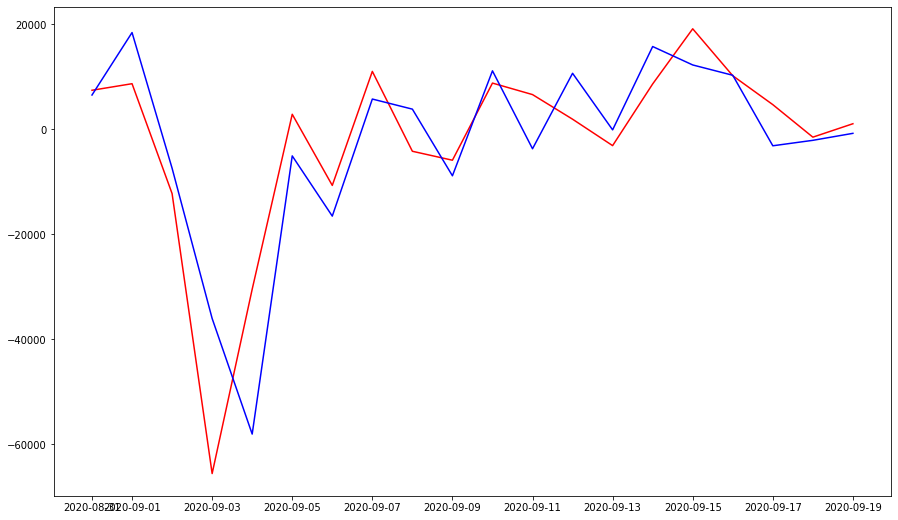

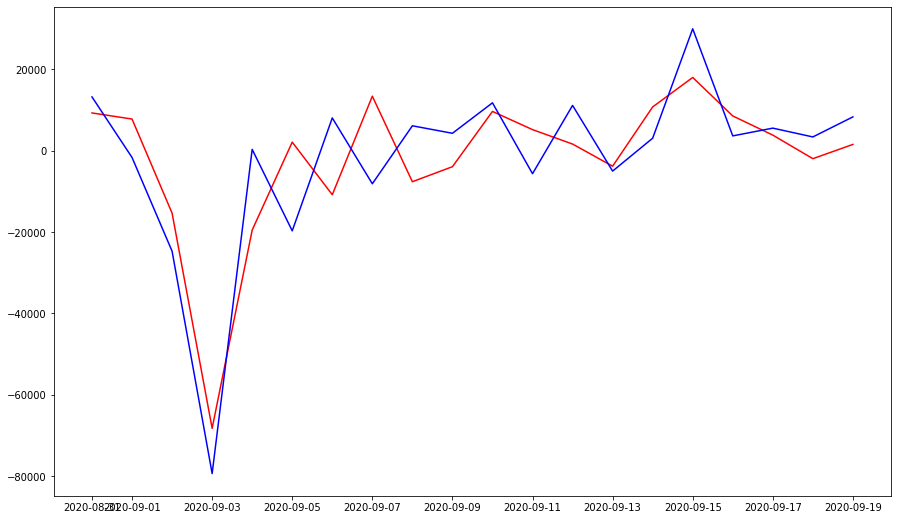

In [ ]:
for t in targets:
    plot_fc(Y_fcst[t],Y_test[t],xlabel = Y_test.index.names, ylabel=t)

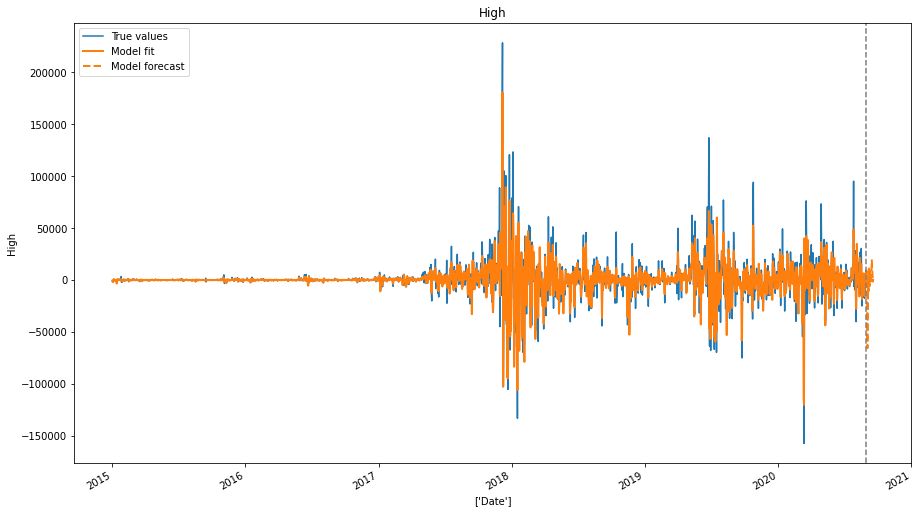

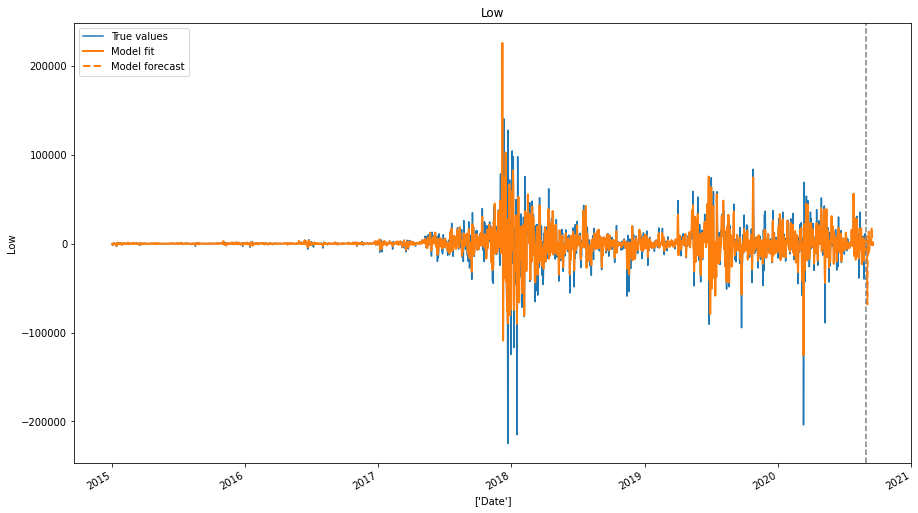

In [ ]:
for target in targets:
    plot_model(Y_train[target], Y_pred[target], Y_fcst[target], 
               xlabel = Y.index.names, ylabel=target, title=target)

#### Creator: Anu Rithiga B , Github: [Profile - Iamgrootsh7](https://github.com/iamgrootsh7)